In [1]:
import numpy as np
import pickle
import os
import json
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import torch.nn as nn
from prettytable import PrettyTable
import pandas as pd
import copy
import sys
import pprint
sys.path.append('D:/FPTAI/Code/SNN/understand_pai/')

from Utils import load
import tinyimagenet_resnet_modified as tinyimagenet_resnet
import lottery_resnet_modified as lottery_resnet


def load_model(model_architecture, model_class):
    lottery_models = {
        'resnet20': lottery_resnet.resnet20,
        'resnet32': lottery_resnet.resnet32,
        'resnet44': lottery_resnet.resnet44,
        'resnet56': lottery_resnet.resnet56,
        'resnet110': lottery_resnet.resnet110,
        'resnet1202': lottery_resnet.resnet1202,
        'wide-resnet20': lottery_resnet.wide_resnet20,
        'wide-resnet32': lottery_resnet.wide_resnet32,
        'wide-resnet44': lottery_resnet.wide_resnet44,
        'wide-resnet56': lottery_resnet.wide_resnet56,
        'wide-resnet110': lottery_resnet.wide_resnet110,
        'wide-resnet1202': lottery_resnet.wide_resnet1202,
        'narrow-resnet20': lottery_resnet.narrow_resnet20
    }
    tinyimagenet_models = {
        'resnet18' : tinyimagenet_resnet.resnet18,
        'resnet34' : tinyimagenet_resnet.resnet34,
        'resnet50' : tinyimagenet_resnet.resnet50,
        'resnet101' : tinyimagenet_resnet.resnet101,
        'resnet152' : tinyimagenet_resnet.resnet152,
        'wide-resnet18' : tinyimagenet_resnet.wide_resnet18,
        'wide-resnet34' : tinyimagenet_resnet.wide_resnet34,
        'wide-resnet50' : tinyimagenet_resnet.wide_resnet50,
        'wide-resnet101' : tinyimagenet_resnet.wide_resnet101,
        'wide-resnet152' : tinyimagenet_resnet.wide_resnet152,
    }

    models = {
        'lottery' : lottery_models,
        'tinyimagenet' : tinyimagenet_models,
    }
    if model_class == 'imagenet':
        print("WARNING: ImageNet models do not implement `dense_classifier`.")
    return models[model_class][model_architecture]

    

def read_performance(path='./', model_class='lottery', model='resnet18', pruner='grasp', compression=100, seed=None, shuffling=False):
    if shuffling:
        path = f'{path}/compression_{int(compression)}/{pruner}/seed_{seed}/{pruner}_{compression}_performance.log'
    else:
        path = f'{path}/compression_{int(compression)}/{pruner}/seed_{seed}/{pruner}_{compression}_performance.log'
    # path = f'{path}/compression_{int(compression)}/{pruner}/{pruner}_{compression}_performance.log'
    with open(path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        if 'Final' in line:
            line = line.strip().split()
            acc = float(line[-2])
            break
    return acc


### OUrs paper

In [2]:

def stat_eff_metric(path='./', model_class='lottery', model='resnet18', pruner='grasp', compression=100, seed=None, shuffling=False):
    if 'mask' in path:
        with open(path, 'rb') as f:
            data = pickle.load(f)
        masks = data['masks']
        out_fea, in_fea, _, _ = masks[-1].shape
        masks[-1] = masks[-1].reshape(out_fea, in_fea)
    else:
        if shuffling:
            path = f'{path}/compression_{int(compression)}/{pruner}/shuffling_seeds/seed_{seed}'
        else:
            path = f'{path}/compression_{int(compression)}/{pruner}/seed_{seed}'
        
        # path = f'{path}/compression_{int(compression)}/{pruner}/default_seed'
        # Load stored mask
        with open(f'{path}/{pruner}_{compression}.pkl', 'rb') as f:
            data = pickle.load(f)
        masks = data['mask']


    if 'cifar10_' in model:
        model = model.replace('cifar10_', '')
        input_shape, num_classes = load.dimension('cifar10')
    elif 'cifar100_' in model:
        model = model.replace('cifar100_', '')
        input_shape, num_classes = load.dimension('cifar100')
    elif 'tiny-imagenet_' in model:
        model = model.replace('tiny-imagenet_', '')
        input_shape, num_classes = load.dimension('tiny-imagenet')
    else:
        print('')

    # Load model and convert it to double to avoid overflow 
    if 'resnet' in model:
        net = load_model(model, model_class)(input_shape, 
                                num_classes).double()

    # Load model without batchnorm since it normalize the values of neurons
    if 'vgg' in model:
        model = model.replace('-bn', '')
        net = load.model(model, model_class)(input_shape, 
                                        num_classes).double()
    c, h, w = input_shape


    i = 0

    with torch.no_grad():
        for name, param in net.named_parameters():
            if 'shortcut' in name:
                continue
            print(name, '\t', param.shape)
            print(masks[i].shape)
            i += 1

    with torch.no_grad():
        # Cast all params to ones
        for name, param in net.named_parameters():
            param.copy_(torch.ones_like(param))
        
        # Assign stored mask to the buffered mask of the model
        for name, mask in net.named_buffers():
            # name format 'blocks.x.conv1.weight_mask' with shape [32,32,3,3]
            # or  'fc.weight_mask' with shape [10, 64]
            if 'weight_mask' in name and len(mask.shape) in [2, 4]:
                mask.copy_(torch.tensor(masks[i]))
                i += 1

    # Put input ones through the subnet and backward
    x = torch.ones((1, c, h, w)).double()
    y = net(x)
    loss = y.sum()
    # loss
    loss.backward()

    ###########
    # EFFECTIVE PATHS
    ###########
    eff_paths = loss.item()

    # all_params = 0.
    # for name, mask in net.named_buffers():
    #     if 'weight_mask' in name and len(mask.shape) in [2,4]:
    #         all_params += torch.numel(mask)
    # all_params = all_params * 10**(-float(compression/100))
    # return all_params


    # Compute unpruned channel
    table = PrettyTable(['Layer', '#Effective Channel'])
    table.align['Layer'] = 'c'
    df = {'Layer':[], '#Effective Channel':[], '#Unpruned Channel': []}
    n_layers = len(masks)
    i = 0   # index of stored mask
    all_unpuned = 0 # all unpruned neurons
    layer_id = 0    # index of layer
    for name, param in net.named_parameters():
        # Iterate over all layers
        if 'weight' in name and len(param.shape) in [4]:  # Consider conv layers 
            # Ignore the shortcut layers
            if 'shortcut' in name:
                i += 1 
                continue
            # print(masks[i].shape)
            # print(masks[i+1].shape, '\n')
            if i != 0:
                sum_along_in_channels = np.sum(masks[i], axis=(0,2,3))
                sum_along_out_channels = np.sum(masks[i-1], axis=(1,2,3))
                sum_along_both = sum_along_in_channels + sum_along_out_channels
            else:
                sum_along_both = np.sum(masks[i], axis=(0,2,3))
            n_unpruned = np.where(sum_along_both > 0, 1, 0).sum()
            all_unpuned += n_unpruned
            # table.add_row([f'{layer_id}', n_e])
            # df['Layer'].append(layer_id)
            df['#Unpruned Channel'].append(n_unpruned)

            i += 1
            layer_id += 1

        if 'weight' in name and len(param.shape) in [2]:
            sum_along_in_features = np.sum(masks[i], axis=0)
            n_unpruned = np.where(sum_along_in_features > 0, 1, 0).sum()
            all_unpuned += n_unpruned
            # table.add_row([f'pre_output', n_e])
            # print('pre ', name, '\t', n_e)
            # df['Layer'].append('Pre_Output')
            df['#Unpruned Channel'].append(n_unpruned)

            sum_along_out_features = np.sum(masks[i], axis=1)
            n_unpruned = np.where(sum_along_out_features > 0, 1, 0).sum()
            all_unpuned += n_unpruned
            # table.add_row([f'output', n_e])
            # print(name, '\t', n_e)
            # df['Layer'].append('Output')
            df['#Unpruned Channel'].append(n_unpruned)

    ###########
    # EFFECTIVE PARAMS
    ###########
    eff_params = 0.
    with torch.no_grad():
        i = 0
        for name, param in net.named_parameters():
            # name format blocks.4.conv1.weight with shape [32,32,3,3]
            # or fc.weight with shape [10,64]
            # or blocks.6.shortcut.0.weight with shape [64,32,1,1]
            if 'weight' in name and len(param.shape) in [2, 4]:
                masks[i] = torch.where(param.grad.data != 0, 1, 0).numpy()
                eff_params += np.sum(masks[i])
                i += 1

    ###########
    # EFFECTIVE CHANNELS
    ###########
    # stat the effective neurons or channels
    
    i = 0   # index of stored mask
    all_n_e = 0 # all effective neurons
    layer_id = 0    # index of layer
    for name, param in net.named_parameters():
        # Iterate over all layers
        if 'weight' in name and len(param.shape) in [4]:  # Consider conv layers 
            # Ignore the shortcut layers
            if 'shortcut' in name:
                i += 1 
                continue
            
            sum_along_in_channels = np.sum(masks[i], axis=(0,2,3))
            n_e = np.where(sum_along_in_channels > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'{layer_id}', n_e])
            df['Layer'].append(layer_id)
            df['#Effective Channel'].append(n_e)

            i += 1
            layer_id += 1

        if 'weight' in name and len(param.shape) in [2]:
            sum_along_in_features = np.sum(masks[i], axis=0)
            n_e = np.where(sum_along_in_features > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'pre_output', n_e])
            # print('pre ', name, '\t', n_e)
            df['Layer'].append('Pre_Output')
            df['#Effective Channel'].append(n_e)

            sum_along_out_features = np.sum(masks[i], axis=1)
            n_e = np.where(sum_along_out_features > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'output', n_e])
            # print(name, '\t', n_e)
            df['Layer'].append('Output')
            df['#Effective Channel'].append(n_e)
        else:
            continue

    eff_neurons = all_n_e

    data = table.get_string()
    # with open(f'{path}/count_effective_node_1.txt', 'w') as f:
    #     f.write(data)
    
    # df1 = pd.DataFrame.from_dict(df)
    # df1.to_csv(f'{path}/count_effective_node_1.csv', index=False)
    # print(df1)

    return df, eff_paths, eff_neurons, eff_params, all_unpuned

In [ ]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 200
pruner = 'snip'
seed = 1

df, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                    path=f'./mask_2 copy.pkl', 
                                                                    model=model, 
                                                                    model_class=model_class, 
                                                                    pruner=pruner, 
                                                                    compression=compression,
                                                                    seed=seed,                  
                                                                    )

In [21]:
all_unpuned

318

In [24]:
sum(df['#Unpruned Channel'])

318

In [36]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compressions = [25, 50,100,150,200,250,300,350]
pruners = ['snip', 'rand', 'synflow', 'impsynflow_2_15']
seeds = [1,2,3,4,5]


results = []
for pruner in pruners:
    df = {}
    for compression in compressions:
        df[str(compression)] = {}
        avg_eff_neurons = 0
        avg_in_eff_neurons = 0 
        for seed in seeds:
            _, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                                path=f'./{model}/uniform/pre_epoch_0/', 
                                                                                model=model, 
                                                                                model_class=model_class, 
                                                                                pruner=pruner, 
                                                                                compression=compression,
                                                                                seed=seed,                  
                                                                                )

            avg_eff_neurons += eff_neurons / len(seeds)
            avg_in_eff_neurons =+ (all_unpuned-eff_neurons) / len(seeds)
        df[str(compression)]['Eff_nodes'] = avg_eff_neurons  
        df[str(compression)]['Ineff_nodes'] = avg_in_eff_neurons
    df = pd.DataFrame.from_dict(df)
    results.append(df)
    


In [37]:
res = pd.concat(results, axis=0)
res

,25,50,100,150,200,250,300,350
Eff_nodes,701.0,610.6,468.4,330.8,191.2,83.4,27.0,4.0
Ineff_nodes,0.0,8.2,17.2,20.2,33.6,25.4,22.4,10.8
Eff_nodes,701.0,699.8,680.0,642.4,474.8,8.8,0.0,0.0
Ineff_nodes,0.0,0.0,0.0,2.2,26.8,97.6,61.6,25.8
Eff_nodes,701.0,608.8,416.8,257.4,147.2,85.0,46.2,26.6
Ineff_nodes,0.0,0.0,0.0,0.0,0.6,0.0,0.2,0.2
Eff_nodes,701.0,651.8,508.6,387.4,274.0,136.0,51.0,27.2
Ineff_nodes,0.0,0.0,0.6,1.0,0.8,0.8,1.6,2.2


### Rare Gem

In [10]:

def stat_eff_metric(path='./', model_class='lottery', model='resnet18', pruner='grasp', compression=100, seed=None, shuffling=False):

    with open(path, 'rb') as f:
        data = pickle.load(f)
    masks = data['masks']
    out_fea, in_fea, _, _ = masks[-1].shape
    masks[-1] = masks[-1].reshape(out_fea, in_fea)
   

    if 'cifar10_' in model:
        model = model.replace('cifar10_', '')
        input_shape, num_classes = load.dimension('cifar10')
    elif 'cifar100_' in model:
        model = model.replace('cifar100_', '')
        input_shape, num_classes = load.dimension('cifar100')
    elif 'tiny-imagenet_' in model:
        model = model.replace('tiny-imagenet_', '')
        input_shape, num_classes = load.dimension('tiny-imagenet')
    else:
        print('')

    # Load model and convert it to double to avoid overflow 
    if 'resnet' in model:
        net = load_model(model, model_class)(input_shape, 
                                num_classes).double()

    # Load model without batchnorm since it normalize the values of neurons
    if 'vgg' in model:
        model = model.replace('-bn', '')
        net = load.model(model, model_class)(input_shape, 
                                        num_classes).double()
    c, h, w = input_shape


    i = 0

    # with torch.no_grad():
    #     # for name, param in net.named_parameters():
    #     #     if 'shortcut' in name or 'bias' in name:
    #     #         continue
    #     #     print(name, '\t', param.shape)
    #     #     print(masks[i].shape)

    with torch.no_grad():
        # Cast all params to ones
        for name, param in net.named_parameters():
            param.copy_(torch.ones_like(param))
        
        # Assign stored mask to the buffered mask of the model
        for name, mask in net.named_buffers():
            # print(f'{name} \t {mask.shape}')
            if 'shortcut' in name or 'bias' in name:
                continue
            # print(f'Layer {i} {masks[i].shape}')
            masks[i] = np.where(masks[i] == 0, 0, 1)
            # name format 'blocks.x.conv1.weight_mask' with shape [32,32,3,3]
            # or  'fc.weight_mask' with shape [10, 64]
            if 'weight_mask' in name and len(mask.shape) in [2, 4]:
                mask.copy_(torch.tensor(masks[i]))
                i += 1

    # Put input ones through the subnet and backward
    x = torch.ones((1, c, h, w)).double()
    y = net(x)
    loss = y.sum()
    # loss
    loss.backward()

    ###########
    # EFFECTIVE PATHS
    ###########
    eff_paths = loss.item()

    # all_params = 0.
    # for name, mask in net.named_buffers():
    #     if 'weight_mask' in name and len(mask.shape) in [2,4]:
    #         all_params += torch.numel(mask)
    # all_params = all_params * 10**(-float(compression/100))
    # return all_params


    # Compute unpruned channel
    table = PrettyTable(['Layer', '#Effective Channel'])
    table.align['Layer'] = 'c'
    df = {'Layer':[], '#Effective Channel':[], '#Unpruned Channel': []}
    n_layers = len(masks)
    i = 0   # index of stored mask
    all_unpuned = 0 # all unpruned neurons
    layer_id = 0    # index of layer
    for name, param in net.named_parameters():
        # Iterate over all layers
        if 'weight' in name and len(param.shape) in [4]:  # Consider conv layers 
            # Ignore the shortcut layers
            if 'shortcut' in name or 'bias' in name:
                # i += 1 
                continue
            # print(masks[i].shape)
            # print(masks[i+1].shape, '\n')
            if i != 0:
                sum_along_in_channels = np.sum(masks[i], axis=(0,2,3))
                sum_along_out_channels = np.sum(masks[i-1], axis=(1,2,3))
                sum_along_both = sum_along_in_channels + sum_along_out_channels
            else:
                sum_along_both = np.sum(masks[i], axis=(0,2,3))
            n_unpruned = np.where(sum_along_both > 0, 1, 0).sum()
            all_unpuned += n_unpruned
            # table.add_row([f'{layer_id}', n_e])
            # df['Layer'].append(layer_id)
            df['#Unpruned Channel'].append(n_unpruned)

            i += 1
            layer_id += 1

        if 'weight' in name and len(param.shape) in [2]:
            sum_along_in_features = np.sum(masks[i], axis=0)
            n_unpruned = np.where(sum_along_in_features > 0, 1, 0).sum()
            all_unpuned += n_unpruned
            # table.add_row([f'pre_output', n_e])
            # print('pre ', name, '\t', n_e)
            # df['Layer'].append('Pre_Output')
            df['#Unpruned Channel'].append(n_unpruned)

            sum_along_out_features = np.sum(masks[i], axis=1)
            n_unpruned = np.where(sum_along_out_features > 0, 1, 0).sum()
            all_unpuned += n_unpruned
            # table.add_row([f'output', n_e])
            # print(name, '\t', n_e)
            # df['Layer'].append('Output')
            df['#Unpruned Channel'].append(n_unpruned)

    ###########
    # EFFECTIVE PARAMS
    ###########
    eff_params = 0.
    with torch.no_grad():
        i = 0
        for name, param in net.named_parameters():
            # name format blocks.4.conv1.weight with shape [32,32,3,3]
            # or fc.weight with shape [10,64]
            # ignore shortcut and bias
            if 'shortcut' in name or 'bias' in name:
                # i += 1 
                continue
            if 'weight' in name and len(param.shape) in [2, 4]:
                masks[i] = torch.where(param.grad.data != 0, 1, 0).numpy()
                eff_params += np.sum(masks[i])
                i += 1

    ###########
    # EFFECTIVE CHANNELS
    ###########
    # stat the effective neurons or channels
    
    i = 0   # index of stored mask
    all_n_e = 0 # all effective neurons
    layer_id = 0    # index of layer
    for name, param in net.named_parameters():
        # Iterate over all layers
        if 'weight' in name and len(param.shape) in [4]:  # Consider conv layers 
            # Ignore the shortcut layers
            if 'shortcut' in name or 'bias' in name:
                # i += 1 
                continue
            
            sum_along_in_channels = np.sum(masks[i], axis=(0,2,3))
            n_e = np.where(sum_along_in_channels > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'{layer_id}', n_e])
            df['Layer'].append(layer_id)
            df['#Effective Channel'].append(n_e)

            i += 1
            layer_id += 1

        if 'weight' in name and len(param.shape) in [2]:
            sum_along_in_features = np.sum(masks[i], axis=0)
            n_e = np.where(sum_along_in_features > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'pre_output', n_e])
            # print('pre ', name, '\t', n_e)
            df['Layer'].append('Pre_Output')
            df['#Effective Channel'].append(n_e)

            sum_along_out_features = np.sum(masks[i], axis=1)
            n_e = np.where(sum_along_out_features > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'output', n_e])
            # print(name, '\t', n_e)
            df['Layer'].append('Output')
            df['#Effective Channel'].append(n_e)
        else:
            continue

    eff_neurons = all_n_e

    data = table.get_string()
    print(table)
    # with open(f'{path}/count_effective_node_1.txt', 'w') as f:
    #     f.write(data)
    
    # df1 = pd.DataFrame.from_dict(df)
    # df1.to_csv(f'{path}/count_effective_node_1.csv', index=False)
    # print(df1)

    return df, eff_paths, eff_neurons, eff_params, all_unpuned

##### Run

##### Sparsity 99.44% - Acc 37.28

In [3]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 200
pruner = 'snip'
seed = 1

df, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                    path=f'./RareGem_cifar10_resnet20/sparsity_0.56/mask_2.pkl', 
                                                                    model=model, 
                                                                    model_class=model_class, 
                                                                    pruner=pruner, 
                                                                    compression=compression,
                                                                    seed=seed,                  
                                                                    )

In [5]:
print(f'Eff nodes: \t {eff_neurons}')
print(f'Eff param: \t {eff_params}')
print(f'Eff paths: \t {eff_paths}')
print(f'Ineff nodes: \t {all_unpuned-eff_neurons}')
all_unpuned

Eff nodes: 	 437
Eff param: 	 1269.0
Eff paths: 	 7921424560.0
Ineff nodes: 	 172


609

#### Sparsity 99.41% - Acc 65.72

In [6]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 200
pruner = 'snip'
seed = 1

df, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                    path=f'./RareGem_cifar10_resnet20/sparsity_0.59/mask_2.pkl', 
                                                                    model=model, 
                                                                    model_class=model_class, 
                                                                    pruner=pruner, 
                                                                    compression=compression,
                                                                    seed=seed,                  
                                                                    )

print(f'Eff nodes: \t {eff_neurons}')
print(f'Eff param: \t {eff_params}')
print(f'Eff paths: \t {eff_paths}')
print(f'Ineff nodes: \t {all_unpuned-eff_neurons}')
all_unpuned

Eff nodes: 	 363
Eff param: 	 1566.0
Eff paths: 	 1.0984814734095962e+16
Ineff nodes: 	 34


397

#### Sparsity 99.00% - Acc 46.09

In [6]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 200
pruner = 'snip'
seed = 1

df, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                    path=f'./RareGem_cifar10_resnet20/sparsity_1.0/mask_2.pkl', 
                                                                    model=model, 
                                                                    model_class=model_class, 
                                                                    pruner=pruner, 
                                                                    compression=compression,
                                                                    seed=seed,                  
                                                                    )

print(f'Eff nodes: \t {eff_neurons}')
print(f'Eff param: \t {eff_params}')
print(f'Eff paths: \t {eff_paths}')
print(f'Ineff nodes: \t {all_unpuned-eff_neurons}')
all_unpuned

Eff nodes: 	 536
Eff param: 	 2434.0
Eff paths: 	 2136661521379.0
Ineff nodes: 	 119


655

#### Sparsity 98.56 - Acc 75.22

In [4]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 200
pruner = 'snip'
seed = 1

df, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                    path=f'./RareGem_cifar10_resnet20/sparsity_144/mask_2.pkl', 
                                                                    model=model, 
                                                                    model_class=model_class, 
                                                                    pruner=pruner, 
                                                                    compression=compression,
                                                                    seed=seed,                  
                                                                    )

print(f'Eff nodes: \t {eff_neurons}')
print(f'Eff param: \t {eff_params}')
print(f'Eff paths: \t {eff_paths}')
print(f'Ineff nodes: \t {all_unpuned-eff_neurons}')
all_unpuned

Eff nodes: 	 402
Eff param: 	 3861.0
Eff paths: 	 1.0619251671282233e+23
Ineff nodes: 	 14


416

#### Sparsity 96.68% - Acc 83.23

In [42]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 200
pruner = 'snip'
seed = 1

df, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                    path=f'./RareGem_cifar10_resnet20/sparsity_372/mask_2.pkl', 
                                                                    model=model, 
                                                                    model_class=model_class, 
                                                                    pruner=pruner, 
                                                                    compression=compression,
                                                                    seed=seed,                  
                                                                    )

print(f'Eff nodes: \t {eff_neurons}')
print(f'Eff param: \t {eff_params}')
print(f'Eff paths: \t {eff_paths}')
print(f'Ineff nodes: \t {all_unpuned-eff_neurons}')
all_unpuned

Eff nodes: 	 616
Eff param: 	 9975.0
Eff paths: 	 7.213264915784648e+27
Ineff nodes: 	 18


634

#### Sparsity 90.00% - Acc 85.18

In [11]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 200
pruner = 'snip'
seed = 1

df, eff_paths, eff_neurons, eff_params, all_unpuned = stat_eff_metric(
                                                                    path=f'./RareGem_cifar10_resnet20/sparsity_10.0/mask_2.pkl', 
                                                                    model=model, 
                                                                    model_class=model_class, 
                                                                    pruner=pruner, 
                                                                    compression=compression,
                                                                    seed=seed,                  
                                                                    )

print(f'Eff nodes: \t {eff_neurons}')
print(f'Eff param: \t {eff_params}')
print(f'Eff paths: \t {eff_paths}')
print(f'Ineff nodes: \t {all_unpuned-eff_neurons}')
all_unpuned

+------------+--------------------+
|   Layer    | #Effective Channel |
+------------+--------------------+
|     0      |         3          |
|     1      |         16         |
|     2      |         16         |
|     3      |         16         |
|     4      |         16         |
|     5      |         16         |
|     6      |         16         |
|     7      |         16         |
|     8      |         32         |
|     9      |         32         |
|     10     |         32         |
|     11     |         32         |
|     12     |         32         |
|     13     |         32         |
|     14     |         64         |
|     15     |         64         |
|     16     |         64         |
|     17     |         64         |
|     18     |         64         |
| pre_output |         64         |
|   output   |         10         |
+------------+--------------------+
Eff nodes: 	 701
Eff param: 	 26827.0
Eff paths: 	 1.8186218635716103e+33
Ineff nodes: 	 0


701

In [43]:
eff_params

26709.0

In [44]:
df = pd.DataFrame.from_dict(df)
df

,Layer,#Effective Channel,#Unpruned Channel
0,0,3,3
1,1,16,16
2,2,16,16
3,3,16,16
4,4,16,16
5,5,16,16
6,6,16,16
7,7,16,16
8,8,32,32
9,9,32,32


## LTH

In [3]:
mask = torch.load('./resnet20_cifar10_lth/replicate_42/level_10/main/mask.pth')


In [4]:
type(mask)

dict

In [5]:
for k, v in mask.items():
    print(k, '\t', v.shape)

conv.weight 	 torch.Size([16, 3, 3, 3])
blocks.0.conv1.weight 	 torch.Size([16, 16, 3, 3])
blocks.0.conv2.weight 	 torch.Size([16, 16, 3, 3])
blocks.1.conv1.weight 	 torch.Size([16, 16, 3, 3])
blocks.1.conv2.weight 	 torch.Size([16, 16, 3, 3])
blocks.2.conv1.weight 	 torch.Size([16, 16, 3, 3])
blocks.2.conv2.weight 	 torch.Size([16, 16, 3, 3])
blocks.3.conv1.weight 	 torch.Size([32, 16, 3, 3])
blocks.3.conv2.weight 	 torch.Size([32, 32, 3, 3])
blocks.3.shortcut.0.weight 	 torch.Size([32, 16, 1, 1])
blocks.4.conv1.weight 	 torch.Size([32, 32, 3, 3])
blocks.4.conv2.weight 	 torch.Size([32, 32, 3, 3])
blocks.5.conv1.weight 	 torch.Size([32, 32, 3, 3])
blocks.5.conv2.weight 	 torch.Size([32, 32, 3, 3])
blocks.6.conv1.weight 	 torch.Size([64, 32, 3, 3])
blocks.6.conv2.weight 	 torch.Size([64, 64, 3, 3])
blocks.6.shortcut.0.weight 	 torch.Size([64, 32, 1, 1])
blocks.7.conv1.weight 	 torch.Size([64, 64, 3, 3])
blocks.7.conv2.weight 	 torch.Size([64, 64, 3, 3])
blocks.8.conv1.weight 	 torch.Si

In [6]:
for k, v in mask.items():
    mask[k] = v.cpu().numpy()


In [13]:

def stat_eff_metric(path='./', model_class='lottery', model='resnet18', pruner='grasp', compression=100, seed=None, shuffling=False):
    
    masks = torch.load(path)
    for k, v in masks.items():
        masks[k] = v.cpu().numpy()
    masks = list(masks.values())


    if 'cifar10_' in model:
        model = model.replace('cifar10_', '')
        input_shape, num_classes = load.dimension('cifar10')
    elif 'cifar100_' in model:
        model = model.replace('cifar100_', '')
        input_shape, num_classes = load.dimension('cifar100')
    elif 'tiny-imagenet_' in model:
        model = model.replace('tiny-imagenet_', '')
        input_shape, num_classes = load.dimension('tiny-imagenet')
    else:
        print('')

    # Load model and convert it to double to avoid overflow 
    if 'resnet' in model:
        net = load_model(model, model_class)(input_shape, 
                                num_classes).double()

    # Load model without batchnorm since it normalize the values of neurons
    if 'vgg' in model:
        model = model.replace('-bn', '')
        net = load.model(model, model_class)(input_shape, 
                                        num_classes).double()
    c, h, w = input_shape


    i = 0

    with torch.no_grad():
        # Cast all params to ones
        for name, param in net.named_parameters():
            param.copy_(torch.ones_like(param))
        
        # Assign stored mask to the buffered mask of the model
        for name, mask in net.named_buffers():
            # name format 'blocks.x.conv1.weight_mask' with shape [32,32,3,3]
            # or  'fc.weight_mask' with shape [10, 64]
            if 'weight_mask' in name and len(mask.shape) in [2, 4]:
                mask.copy_(torch.tensor(masks[i]))
                i += 1

    # Put input ones through the subnet and backward
    x = torch.ones((1, c, h, w)).double()
    y = net(x)
    loss = y.sum()
    # loss
    loss.backward()

    ###########
    # EFFECTIVE PATHS
    ###########
    eff_paths = loss.item()

    # all_params = 0.
    # for name, mask in net.named_buffers():
    #     if 'weight_mask' in name and len(mask.shape) in [2,4]:
    #         all_params += torch.numel(mask)
    # all_params = all_params * 10**(-float(compression/100))
    # return all_params

    ###########
    # EFFECTIVE PARAMS
    ###########
    eff_params = 0.
    with torch.no_grad():
        i = 0
        for name, param in net.named_parameters():
            # name format blocks.4.conv1.weight with shape [32,32,3,3]
            # or fc.weight with shape [10,64]
            # or blocks.6.shortcut.0.weight with shape [64,32,1,1]
            if 'weight' in name and len(param.shape) in [2, 4]:
                masks[i] = torch.where(param.grad.data != 0, 1, 0).numpy()
                eff_params += np.sum(masks[i])
                i += 1

    ###########
    # EFFECTIVE CHANNELS
    ###########
    # stat the effective neurons or channels
    
    table = PrettyTable(['Layer', '#Effective Channel'])
    table.align['Layer'] = 'c'
    df = {'Layer':[], '#Effective Channel':[]}
    i = 0   # index of stored mask
    all_n_e = 0 # all effective neurons
    layer_id = 0    # index of layer
    for name, param in net.named_parameters():
        # Iterate over all layers
        if 'weight' in name and len(param.shape) in [4]:  # Consider conv layers 
            # Ignore the shortcut layers
            if 'shortcut' in name:
                i += 1 
                continue
            
            sum_along_in_channels = np.sum(masks[i], axis=(0,2,3))
            n_e = np.where(sum_along_in_channels > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'{layer_id}', n_e])
            df['Layer'].append(layer_id)
            df['#Effective Channel'].append(n_e)

            i += 1
            layer_id += 1

        if 'weight' in name and len(param.shape) in [2]:
            sum_along_in_features = np.sum(masks[i], axis=0)
            n_e = np.where(sum_along_in_features > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'pre_output', n_e])
            # print('pre ', name, '\t', n_e)
            df['Layer'].append('Pre_Output')
            df['#Effective Channel'].append(n_e)

            sum_along_out_features = np.sum(masks[i], axis=1)
            n_e = np.where(sum_along_out_features > 0, 1, 0).sum()
            all_n_e += n_e
            table.add_row([f'output', n_e])
            # print(name, '\t', n_e)
            df['Layer'].append('Output')
            df['#Effective Channel'].append(n_e)
        else:
            continue
    print(table)

    eff_neurons = all_n_e

    data = table.get_string()
    # with open(f'{path}/count_effective_node.txt', 'w') as f:
    #     f.write(data)
    
    # df1 = pd.DataFrame.from_dict(df)
    # df1.to_csv(f'{path}/count_effective_node.csv', index=False)

    return df, eff_paths, eff_neurons, eff_params

### Run

#### Sparsity 96.48 - Acc 86.23

In [9]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 100
pruner = 'snip'
seed = 1

path = './resnet20_cifar10_lth/replicate_118/level_15/main'

df, eff_paths, eff_neurons, eff_params = stat_eff_metric(
                                                        path=f'{path}/mask.pth', 
                                                        model=model, 
                                                        model_class=model_class, 
                                                        pruner=pruner, 
                                                        compression=compression,
                                                        seed=seed,                  
                                                        )

sparsity_file = f'{path}/sparsity_report.json'
with open(sparsity_file) as f:
    sparsity = json.load(f)
s = 100 - sparsity['unpruned'] / sparsity['total'] * 100
print('path:\t', eff_paths)
print('node:\t', eff_neurons)
print('sparsity:\t',s)

+------------+--------------------+
|   Layer    | #Effective Channel |
+------------+--------------------+
|     0      |         3          |
|     1      |         14         |
|     2      |         13         |
|     3      |         16         |
|     4      |         13         |
|     5      |         16         |
|     6      |         14         |
|     7      |         16         |
|     8      |         29         |
|     9      |         32         |
|     10     |         30         |
|     11     |         32         |
|     12     |         29         |
|     13     |         32         |
|     14     |         60         |
|     15     |         60         |
|     16     |         61         |
|     17     |         64         |
|     18     |         52         |
| pre_output |         59         |
|   output   |         10         |
+------------+--------------------+
path:	 1.1152375573647437e+26
node:	 655
sparsity:	 96.48425964207667


In [14]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 100
pruner = 'snip'
seed = 1

path = './resnet20_cifar10_lth/replicate_118/level_9/main'

df, eff_paths, eff_neurons, eff_params = stat_eff_metric(
                                                        path=f'{path}/mask.pth', 
                                                        model=model, 
                                                        model_class=model_class, 
                                                        pruner=pruner, 
                                                        compression=compression,
                                                        seed=seed,                  
                                                        )

sparsity_file = f'{path}/sparsity_report.json'
with open(sparsity_file) as f:
    sparsity = json.load(f)
s = 100 - sparsity['unpruned'] / sparsity['total'] * 100
print('path:\t', eff_paths)
print('node:\t', eff_neurons)
print('sparsity:\t',s)

+------------+--------------------+
|   Layer    | #Effective Channel |
+------------+--------------------+
|     0      |         3          |
|     1      |         15         |
|     2      |         14         |
|     3      |         16         |
|     4      |         13         |
|     5      |         16         |
|     6      |         15         |
|     7      |         16         |
|     8      |         29         |
|     9      |         32         |
|     10     |         31         |
|     11     |         32         |
|     12     |         30         |
|     13     |         32         |
|     14     |         60         |
|     15     |         62         |
|     16     |         62         |
|     17     |         64         |
|     18     |         60         |
| pre_output |         63         |
|   output   |         10         |
+------------+--------------------+
path:	 1.4691107174760827e+35
node:	 675
sparsity:	 86.58045892150493


In [25]:
eff_neurons

638

In [19]:
eff_params

29081.0

#### Sparsity 90.00 - Acc 91.30

In [15]:
model = 'cifar10_resnet20'
model_class = 'lottery'
compression = 100
pruner = 'snip'
seed = 1

path = './resnet20_cifar10_lth/replicate_118/level_10/main'

df, eff_paths, eff_neurons, eff_params = stat_eff_metric(
                                                        path=f'{path}/mask.pth', 
                                                        model=model, 
                                                        model_class=model_class, 
                                                        pruner=pruner, 
                                                        compression=compression,
                                                        seed=seed,                  
                                                        )

sparsity_file = f'{path}/sparsity_report.json'
with open(sparsity_file) as f:
    sparsity = json.load(f)
s = 100 - sparsity['unpruned'] / sparsity['total'] * 100
print('path:\t', eff_paths)
print('node:\t', eff_neurons)
print('sparsity:\t',s)

+------------+--------------------+
|   Layer    | #Effective Channel |
+------------+--------------------+
|     0      |         3          |
|     1      |         15         |
|     2      |         14         |
|     3      |         16         |
|     4      |         13         |
|     5      |         16         |
|     6      |         15         |
|     7      |         16         |
|     8      |         29         |
|     9      |         32         |
|     10     |         31         |
|     11     |         32         |
|     12     |         30         |
|     13     |         32         |
|     14     |         60         |
|     15     |         62         |
|     16     |         62         |
|     17     |         64         |
|     18     |         60         |
| pre_output |         63         |
|   output   |         10         |
+------------+--------------------+
path:	 3.0894271642644783e+33
node:	 675
sparsity:	 89.26488394070049


In [16]:
mask = torch.load('./resnet20_cifar10_lth/replicate_42/level_10/main/mask.pth')
mask.keys()

dict_keys(['conv.weight', 'blocks.0.conv1.weight', 'blocks.0.conv2.weight', 'blocks.1.conv1.weight', 'blocks.1.conv2.weight', 'blocks.2.conv1.weight', 'blocks.2.conv2.weight', 'blocks.3.conv1.weight', 'blocks.3.conv2.weight', 'blocks.3.shortcut.0.weight', 'blocks.4.conv1.weight', 'blocks.4.conv2.weight', 'blocks.5.conv1.weight', 'blocks.5.conv2.weight', 'blocks.6.conv1.weight', 'blocks.6.conv2.weight', 'blocks.6.shortcut.0.weight', 'blocks.7.conv1.weight', 'blocks.7.conv2.weight', 'blocks.8.conv1.weight', 'blocks.8.conv2.weight', 'fc.weight'])

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

conv.weight


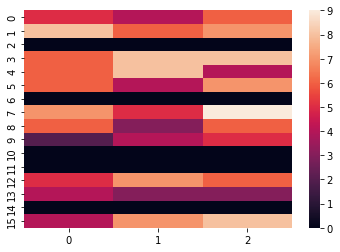

blocks.0.conv1.weight


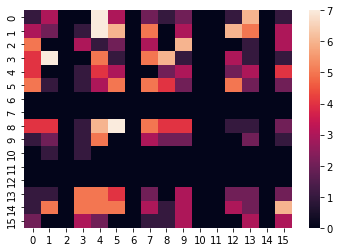

blocks.0.conv2.weight


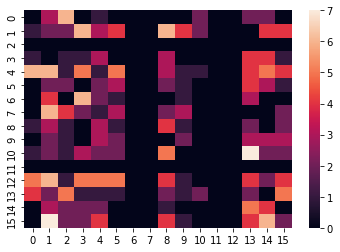

blocks.1.conv1.weight


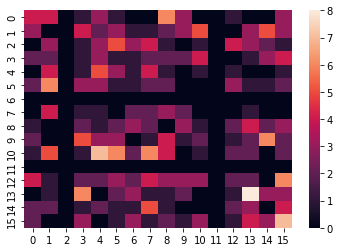

blocks.1.conv2.weight


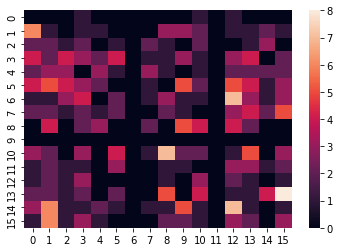

blocks.2.conv1.weight


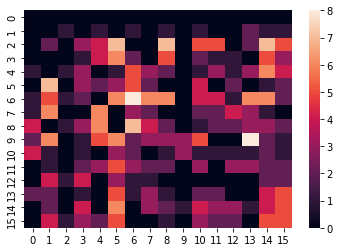

blocks.2.conv2.weight


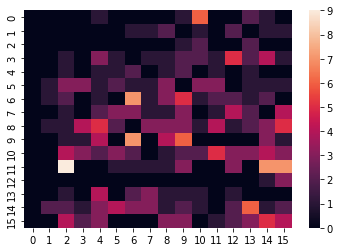

blocks.3.conv1.weight


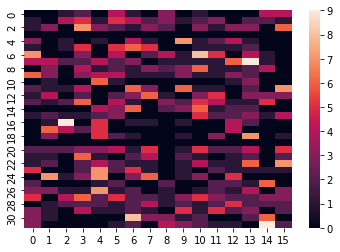

blocks.3.conv2.weight


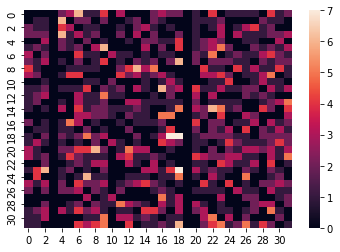

blocks.3.shortcut.0.weight


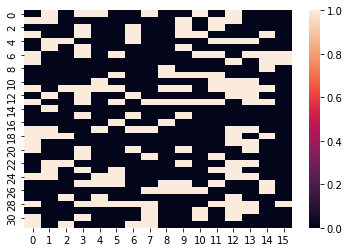

blocks.4.conv1.weight


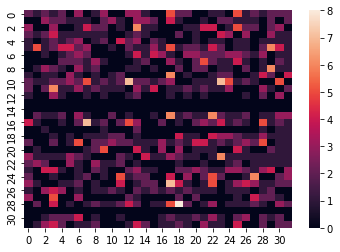

blocks.4.conv2.weight


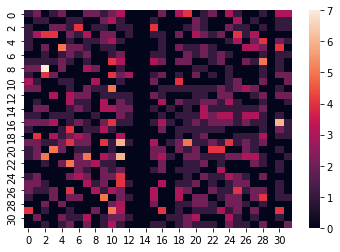

blocks.5.conv1.weight


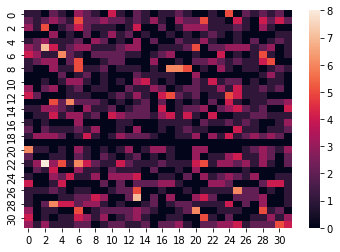

blocks.5.conv2.weight


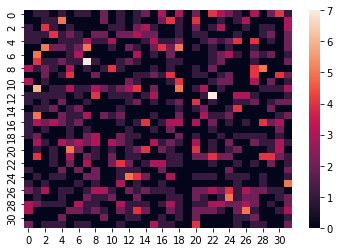

blocks.6.conv1.weight


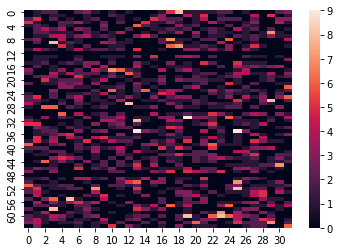

blocks.6.conv2.weight


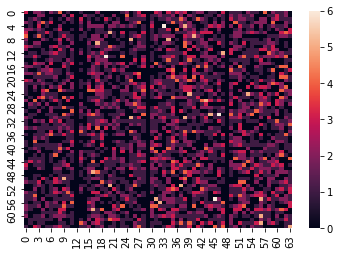

blocks.6.shortcut.0.weight


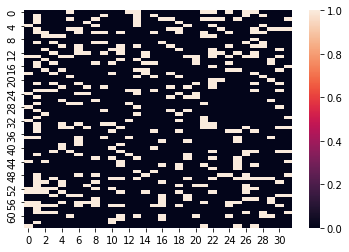

blocks.7.conv1.weight


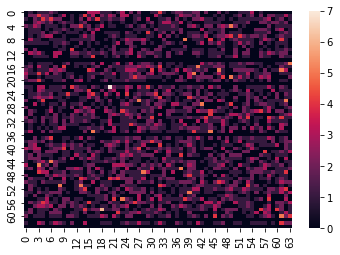

blocks.7.conv2.weight


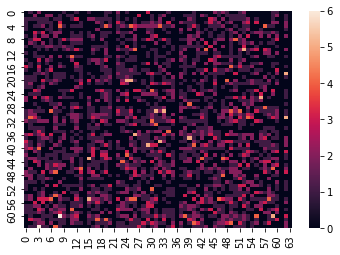

blocks.8.conv1.weight


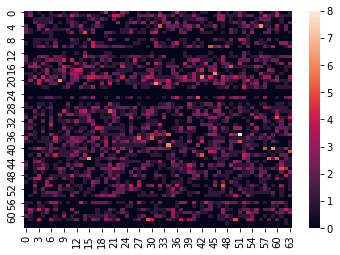

blocks.8.conv2.weight


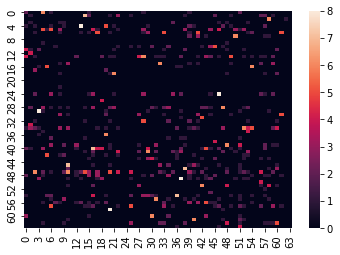

fc.weight


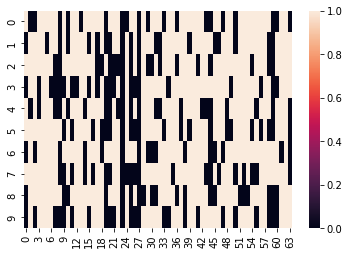

In [41]:
# fig, axs = plt.subplots(6,4)
for i, (k, v) in enumerate(mask.items()):
    print(k)
    if 'conv' in k or 'shortcut' in k:
        v = torch.sum(v, dim=(2,3)).squeeze(-1).cpu().numpy()
        sns.heatmap(v)
        plt.show()
        # plt.plot()
        # break
    else:
        v = v.cpu().numpy()
        sns.heatmap(v)
        # plt.show()
